In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Read NHL_ALL file
ALL = pd.read_csv('NHL_ALL.csv')  

# Create subset data frames by situation
# NHL_ALL = ALL[ALL['situation'] == 'all']
NHL_ALL = ALL.query("situation == 'all' and playoffGame == 0 and season != 2012 and season != 2020")

# # Use only 2008 for small data set for debugging.
# # Drop playoff games from calculations.
# tmp = ALL[ALL["situation"] == "all"]
# NHL_ALL = tmp.query("season == 2008 and playoffGame == 0")

In [70]:
# Append season to team name columns.
NHL_ALL.loc[:, "playerTeam"] = NHL_ALL["playerTeam"] + "_" + NHL_ALL["season"].astype(str)
NHL_ALL.loc[:, "opposingTeam"] = NHL_ALL["opposingTeam"] + "_" + NHL_ALL["season"].astype(str)

In [71]:
# Take necessary columns/discard auxillary data
NHL_ALL = pd.DataFrame(NHL_ALL[["season", "playerTeam", "opposingTeam", "gameId", "goalsFor", "goalsAgainst"]]).set_index("gameId")
NHL_2008 = NHL_ALL.query("season == 2008")
NHL_2009 = NHL_ALL.query("season == 2009")
NHL_2010 = NHL_ALL.query("season == 2010")
NHL_2011 = NHL_ALL.query("season == 2011")
NHL_2013 = NHL_ALL.query("season == 2013")
NHL_2014 = NHL_ALL.query("season == 2014")
NHL_2015 = NHL_ALL.query("season == 2015")
NHL_2016 = NHL_ALL.query("season == 2016")
NHL_2017 = NHL_ALL.query("season == 2017")
NHL_2018 = NHL_ALL.query("season == 2018")
NHL_2019 = NHL_ALL.query("season == 2019")

# create array of all team names
TEAMS_2008 = NHL_2008["playerTeam"].unique()
TEAMS_2009 = NHL_2009["playerTeam"].unique()
TEAMS_2010 = NHL_2010["playerTeam"].unique()
TEAMS_2011 = NHL_2011["playerTeam"].unique()
TEAMS_2013 = NHL_2013["playerTeam"].unique()
TEAMS_2014 = NHL_2014["playerTeam"].unique()
TEAMS_2015 = NHL_2015["playerTeam"].unique()
TEAMS_2016 = NHL_2016["playerTeam"].unique()
TEAMS_2017 = NHL_2017["playerTeam"].unique()
TEAMS_2018 = NHL_2018["playerTeam"].unique()
TEAMS_2019 = NHL_2019["playerTeam"].unique()

TEAMS_ALL = [TEAMS_2008, TEAMS_2009, TEAMS_2010, TEAMS_2011, TEAMS_2013, TEAMS_2014, TEAMS_2015, TEAMS_2016, TEAMS_2017, TEAMS_2018, TEAMS_2019]

['NYR_2019' 'PIT_2019' 'EDM_2019' 'WPG_2019' 'PHI_2019' 'DAL_2019'
 'N.J_2019' 'T.B_2019' 'MIN_2019' 'COL_2019' 'ANA_2019' 'VGK_2019'
 'TOR_2019' 'NYI_2019' 'MTL_2019' 'STL_2019' 'FLA_2019' 'BUF_2019'
 'ARI_2019' 'OTT_2019' 'WSH_2019' 'CBJ_2019' 'CHI_2019' 'NSH_2019'
 'CGY_2019' 'BOS_2019' 'DET_2019' 'VAN_2019' 'CAR_2019' 'S.J_2019'
 'L.A_2019']


In [72]:
X = np.zeros((len(TEAMS_ALL), len(TEAMS_ALL)))
for team in TEAMS_ALL:

    # Create table array of number of games between teams
    NO_GAMES = pd.DataFrame(np.zeros([len(TEAMS_ALL), len(TEAMS_ALL)]), columns=[TEAMS_ALL], index=[TEAMS_ALL])

    # Iterate through NHL_ALL and count games into NO_GAMES
    for index, game in NHL_ALL.iterrows():
        Team = game["playerTeam"]
        Opp = game["opposingTeam"]
        NO_GAMES.loc[Team,Opp] += 1

    # Convert num of games to int values
    NO_GAMES = NO_GAMES.astype(int)

    # Use scipy.optimize.fsolve to solve nonlinear system
    from scipy import optimize

    # Declare variables for matrices
    P = NO_GAMES.to_numpy()
    zeroMat = np.zeros((len(TEAMS_ALL), len(TEAMS_ALL)))
    f = NHL_ALL.groupby(['playerTeam'])['goalsFor'].sum().to_numpy()
    c = NHL_ALL.groupby(['playerTeam'])['goalsAgainst'].sum().to_numpy()
    # Define function to obtain x vector
    def func(x):
        return(np.matmul(np.transpose(x), np.block([[zeroMat, P],[np.transpose(P), zeroMat]]))*x  - np.transpose(np.hstack((f,c))))
    # Call function to get vector of O and V
    x = np.transpose(np.hstack((f/sum(f),c/sum(c))))
    while sum(func(x))**2 > 0.001:
        x = optimize.fsolve(func, x)
    # x includes both offensive strengths and defensive vulnerabilities
    # Split it up
    Offensive_Strength = x[0:int((len(x))/2)]
    Defensive_Vulnerability = x[int((len(x))/2):]


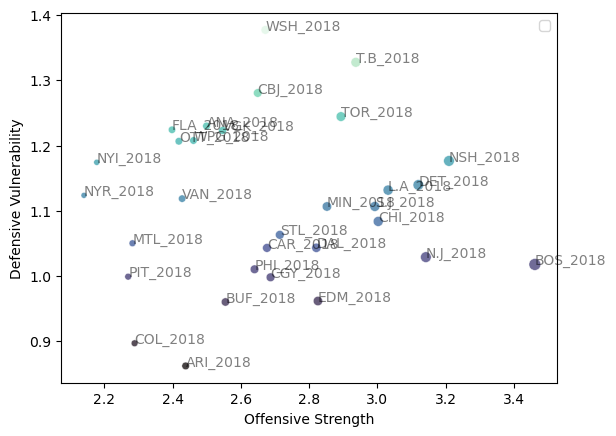

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.scatterplot(
    data = TEAMS,
    x = Offensive_Strength,
    y = Defensive_Vulnerability,
    hue = c, # Goals against. 
    size = f, # Goals for.   
    alpha = 0.75,
    palette = "mako",
)
# Label points.
for i, team in enumerate(TEAMS):
    ax.text(Offensive_Strength[i],
            Defensive_Vulnerability[i],
            team,
            alpha = 0.5)
    
plt.xlabel("Offensive Strength")
plt.ylabel("Defensive Vulnerability")
plt.legend([])
plt.show()

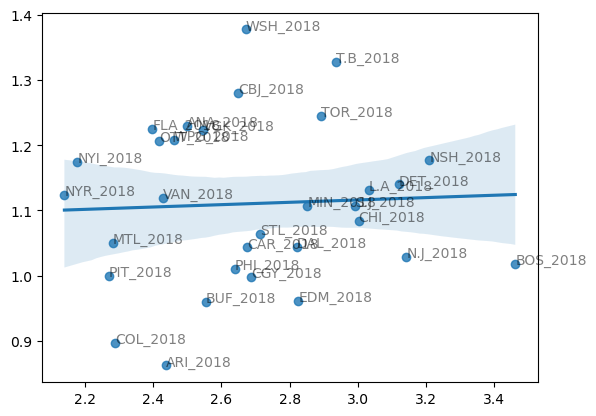

In [ ]:
# Linear regression plot.
ax = sns.regplot(
    x = Offensive_Strength, 
    y = Defensive_Vulnerability
)


# Label points.
for i, team in enumerate(TEAMS):
    ax.text(Offensive_Strength[i],
            Defensive_Vulnerability[i],
            team,
            alpha = 0.5)

plt.show()

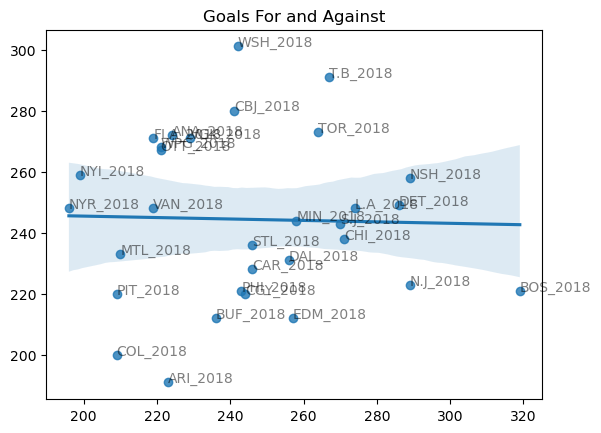

In [ ]:
# GF/GA Linear regression plot.
ax = sns.regplot(
    x = f,
    y = c
)
# Label points.
for i, team in enumerate(TEAMS):
    ax.text(f[i], c[i],
            team,
            alpha = 0.5)
plt.title("Goals For and Against")
plt.show()